In [66]:
import pandas as pd
import json
import seaborn as sb
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [48]:
file_name = "DEBRV_DEHAM_historical_routes.csv"

In [49]:
raw_data = pd.read_csv(file_name)
raw_data.head()

,id,from_seq,to_seq,from_port,to_port,leg_duration,count,points
0,imo_9462794,127,128,DEBRV,DEHAM,36406308,135,"[[8.489074, 53.615707, 1509423228430, 14.0], [..."
1,imo_9454230,196,197,DEBRV,DEHAM,37389167,155,"[[8.48967, 53.614338, 1507290057531, 12.5], [8..."
2,imo_9454230,241,242,DEBRV,DEHAM,35623991,196,"[[8.499015, 53.60522, 1509682757817, 15.9], [8..."
3,imo_9372200,150,151,DEBRV,DEHAM,34345681,156,"[[8.495334, 53.609833, 1511932247447, 11.2], [..."
4,imo_9376048,116,117,DEHAM,DEBRV,32515761,189,"[[9.915167, 53.542168, 1508734759773, 7.6], [9..."


In [50]:
raw_data['id'] = raw_data['id'].astype(str)
raw_data['from_port'] = raw_data['from_port'].astype(str)
raw_data['to_port'] = raw_data['to_port'].astype(str)

In [51]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            728 non-null    object
 1   from_seq      728 non-null    int64 
 2   to_seq        728 non-null    int64 
 3   from_port     728 non-null    object
 4   to_port       728 non-null    object
 5   leg_duration  728 non-null    int64 
 6   count         728 non-null    int64 
 7   points        728 non-null    object
dtypes: int64(4), object(4)
memory usage: 45.6+ KB


In [52]:
#Create a new frame from flatten points list

debrv_deham = raw_data[raw_data.from_port.str.contains("DEBRV")]

data_list = list()
for row in debrv_deham.itertuples(index=False):
    parsed_list = json.loads(row.points)
    for item in parsed_list:
        item.append(row.id)
    data_list += parsed_list

In [53]:
debrv_deham.head()

,id,from_seq,to_seq,from_port,to_port,leg_duration,count,points
0,imo_9462794,127,128,DEBRV,DEHAM,36406308,135,"[[8.489074, 53.615707, 1509423228430, 14.0], [..."
1,imo_9454230,196,197,DEBRV,DEHAM,37389167,155,"[[8.48967, 53.614338, 1507290057531, 12.5], [8..."
2,imo_9454230,241,242,DEBRV,DEHAM,35623991,196,"[[8.499015, 53.60522, 1509682757817, 15.9], [8..."
3,imo_9372200,150,151,DEBRV,DEHAM,34345681,156,"[[8.495334, 53.609833, 1511932247447, 11.2], [..."
6,imo_9297591,118,119,DEBRV,DEHAM,42196071,223,"[[8.488343, 53.61487, 1506326663060, 17.8], [8..."


In [54]:
df = pd.DataFrame(data_list, columns=['longitude', 'latitude', 'timestamp', 'speed', 'vessel_id'])

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81359 entries, 0 to 81358
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  81359 non-null  float64
 1   latitude   81359 non-null  float64
 2   timestamp  81359 non-null  int64  
 3   speed      81331 non-null  float64
 4   vessel_id  81359 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 3.1+ MB


In [56]:
df.head()

,longitude,latitude,timestamp,speed,vessel_id
0,8.489074,53.615707,1509423228430,14.0,imo_9462794
1,8.476499,53.621193,1509423365984,14.8,imo_9462794
2,8.463407,53.626442,1509423498599,15.8,imo_9462794
3,8.450949,53.631893,1509423624892,15.6,imo_9462794
4,8.438425,53.637140,1509423750263,15.7,imo_9462794


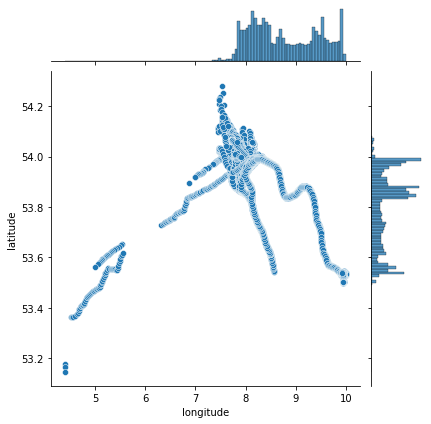

In [57]:
sb.jointplot(data=df, y="latitude", x="longitude")

In [58]:
Q1 = df.quantile(0.30)
Q3 = df.quantile(0.50)
IQR = Q3 - Q1
print(IQR)
print(Q1.longitude)
print(Q3.longitude)

longitude    3.940672e-01
latitude     1.286798e-01
timestamp    3.018388e+09
speed        2.000000e+00
dtype: float64
8.271204800000001
8.665272


In [59]:
index = df[(df['longitude'] <=(Q1.longitude - 1.5*IQR.longitude))|(df['longitude'] >= (Q3.longitude + 1.5*IQR.longitude))].index
#index = df[(df['longitude'] <= Q1.longitude)|(df['longitude'] >= Q3.longitude)].index
df.drop(index, inplace=True)

index = df[(df['latitude'] <= (Q1.latitude - 1.5*IQR.latitude))|(df['latitude'] >= (Q3.latitude + 1.5*IQR.latitude))].index
#index = df[(df['latitude'] <= Q1.latitude)|(df['latitude'] >= Q3.latitude)].index
df.drop(index, inplace=True)

df.describe()

,longitude,latitude,timestamp,speed
count,53895.000000,53895.000000,5.389500e+04,53876.000000
mean,8.411942,53.863389,1.504513e+12,13.866261
std,0.388979,0.102694,4.406081e+09,4.555033
min,7.681767,53.540670,1.496311e+12,0.000000
25%,8.106555,53.831855,1.500968e+12,12.600000
50%,8.355362,53.875400,1.504789e+12,14.800000
75%,8.698467,53.955141,1.508123e+12,16.600000
max,9.256353,54.034485,1.512036e+12,102.300000


In [60]:
coords = df[['latitude','longitude']]

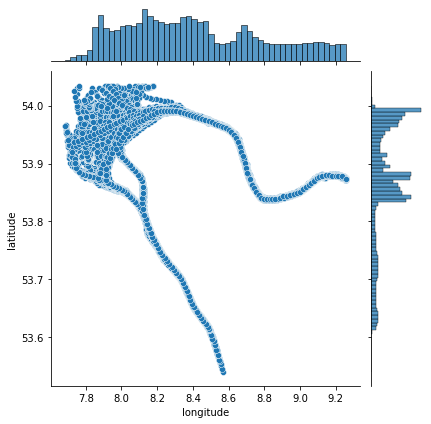

In [61]:
sb.jointplot(data=coords, y="latitude", x="longitude")

In [62]:
#db = DBSCAN(eps=0.6, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
db = DBSCAN(eps=0.5, min_samples=1).fit(coords)

In [63]:
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))

In [64]:
num_clusters

1

In [67]:
k_means = KMeans(n_clusters=1000).fit(coords)

In [68]:
k_means.labels_

array([528,  19, 332, ..., 671, 940, 117])

In [70]:
k_means.cluster_centers_

array([[53.84505721,  8.77016802],
       [53.82257545,  8.1088113 ],
       [53.87954492,  9.19148658],
       ...,
       [53.84027037,  8.88499189],
       [53.93542274,  8.65624641],
       [53.87693275,  9.10476332]])